# Customer Churn Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Mobile Customer Departure**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)

---

## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_

Losing customers is costly for any business.  Identifying unhappy customers early on gives you a chance to offer them incentives to stay.  This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us–leaving a mobile phone operator.  Seems like I can always find fault with my provider du jour! And if my provider knows that I’m thinking of leaving, it can offer timely incentives–I can always use a phone upgrade or perhaps have a new feature activated–and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [29]:
# Get variables from previous notebooks, check on the Modeling section how to do so

In [ ]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-xgboost-churn"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [ ]:
!pip install pandas --upgrade

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display as dis
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from IPython import display 

---
## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.  Let's download and read that dataset in now:

In [14]:
!aws s3 cp s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt ./

download: s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt to ./churn.txt


In [8]:
#DataWrangler Version
#Probably changing the way to capture churn.csv to S3 would be better
#!aws s3 cp s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt ./
churn = pd.read_csv("./churn.txt")
churn.to_csv("churn.csv", index=False)

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "churn/churn.csv")
).upload_file("churn.csv")

# Importing Data on DataWrangler

To start, we will create a new flow and import the raw data to perform analysis and transformations on it. On the left menu, click on "Components and Registries", select "Data Wrangler" on the dropdown, and click "New Flow". This process is shown on the image below.

<img src="media/01-new_flow.png" width="30%" />

As soon as we click on "New Flow", Data Wrangler will be on a loading state. After a couple minutes you should be able to import the raw data on it. While we wait, we can rename our flow by right clicking on the flow tab and choosing "Rename Data Wrangler Flow...".

<img src="media/02-load_new_flow.png" width="100%" />

After Data Wrangler finishes loading, we may proceed importing our data. We'll be importing our data from Amazon S3. The following images guide us through the process.

<img src="media/03-importing_from_s3.png" width="100%" />

Using the search box or the table in the bottom, locate the S3 Bucket where our dataset is stored.

<img src="media/04-choosing_bucket.png" width="100%" />

Choose the "churn.csv" file, disable the "Enable sampling" checkbox, and click "Import". Feel free to check the data preview on the "Preview" session on the bottom!

<img src="media/05-choose_csv_preview.png" width="100%" />

# Data Analysis on Data Wrangler

Next, we are going to analyze our data by understanding feature distribution and how each of them impacts our target column. Data Wrangler allow us to perform such analysis inside user interface, let's start creating these analysis.

To start our analysis, we'll create a summary of our imported data. The summary can be rertieved by adding a new analysis on Data Wrangler. The following images show the step by step to create our table summary.

<img src="media/06-add_first_analysis.png" width="100%" />

<img src="media/07-table_summary_creation.png" width="100%" />

As soon as you click on Preview or entering in your saved analysis, you'll see the table summary as shown in the image below.

<img src="media/08-table_summary_preview.png" width="100%" />
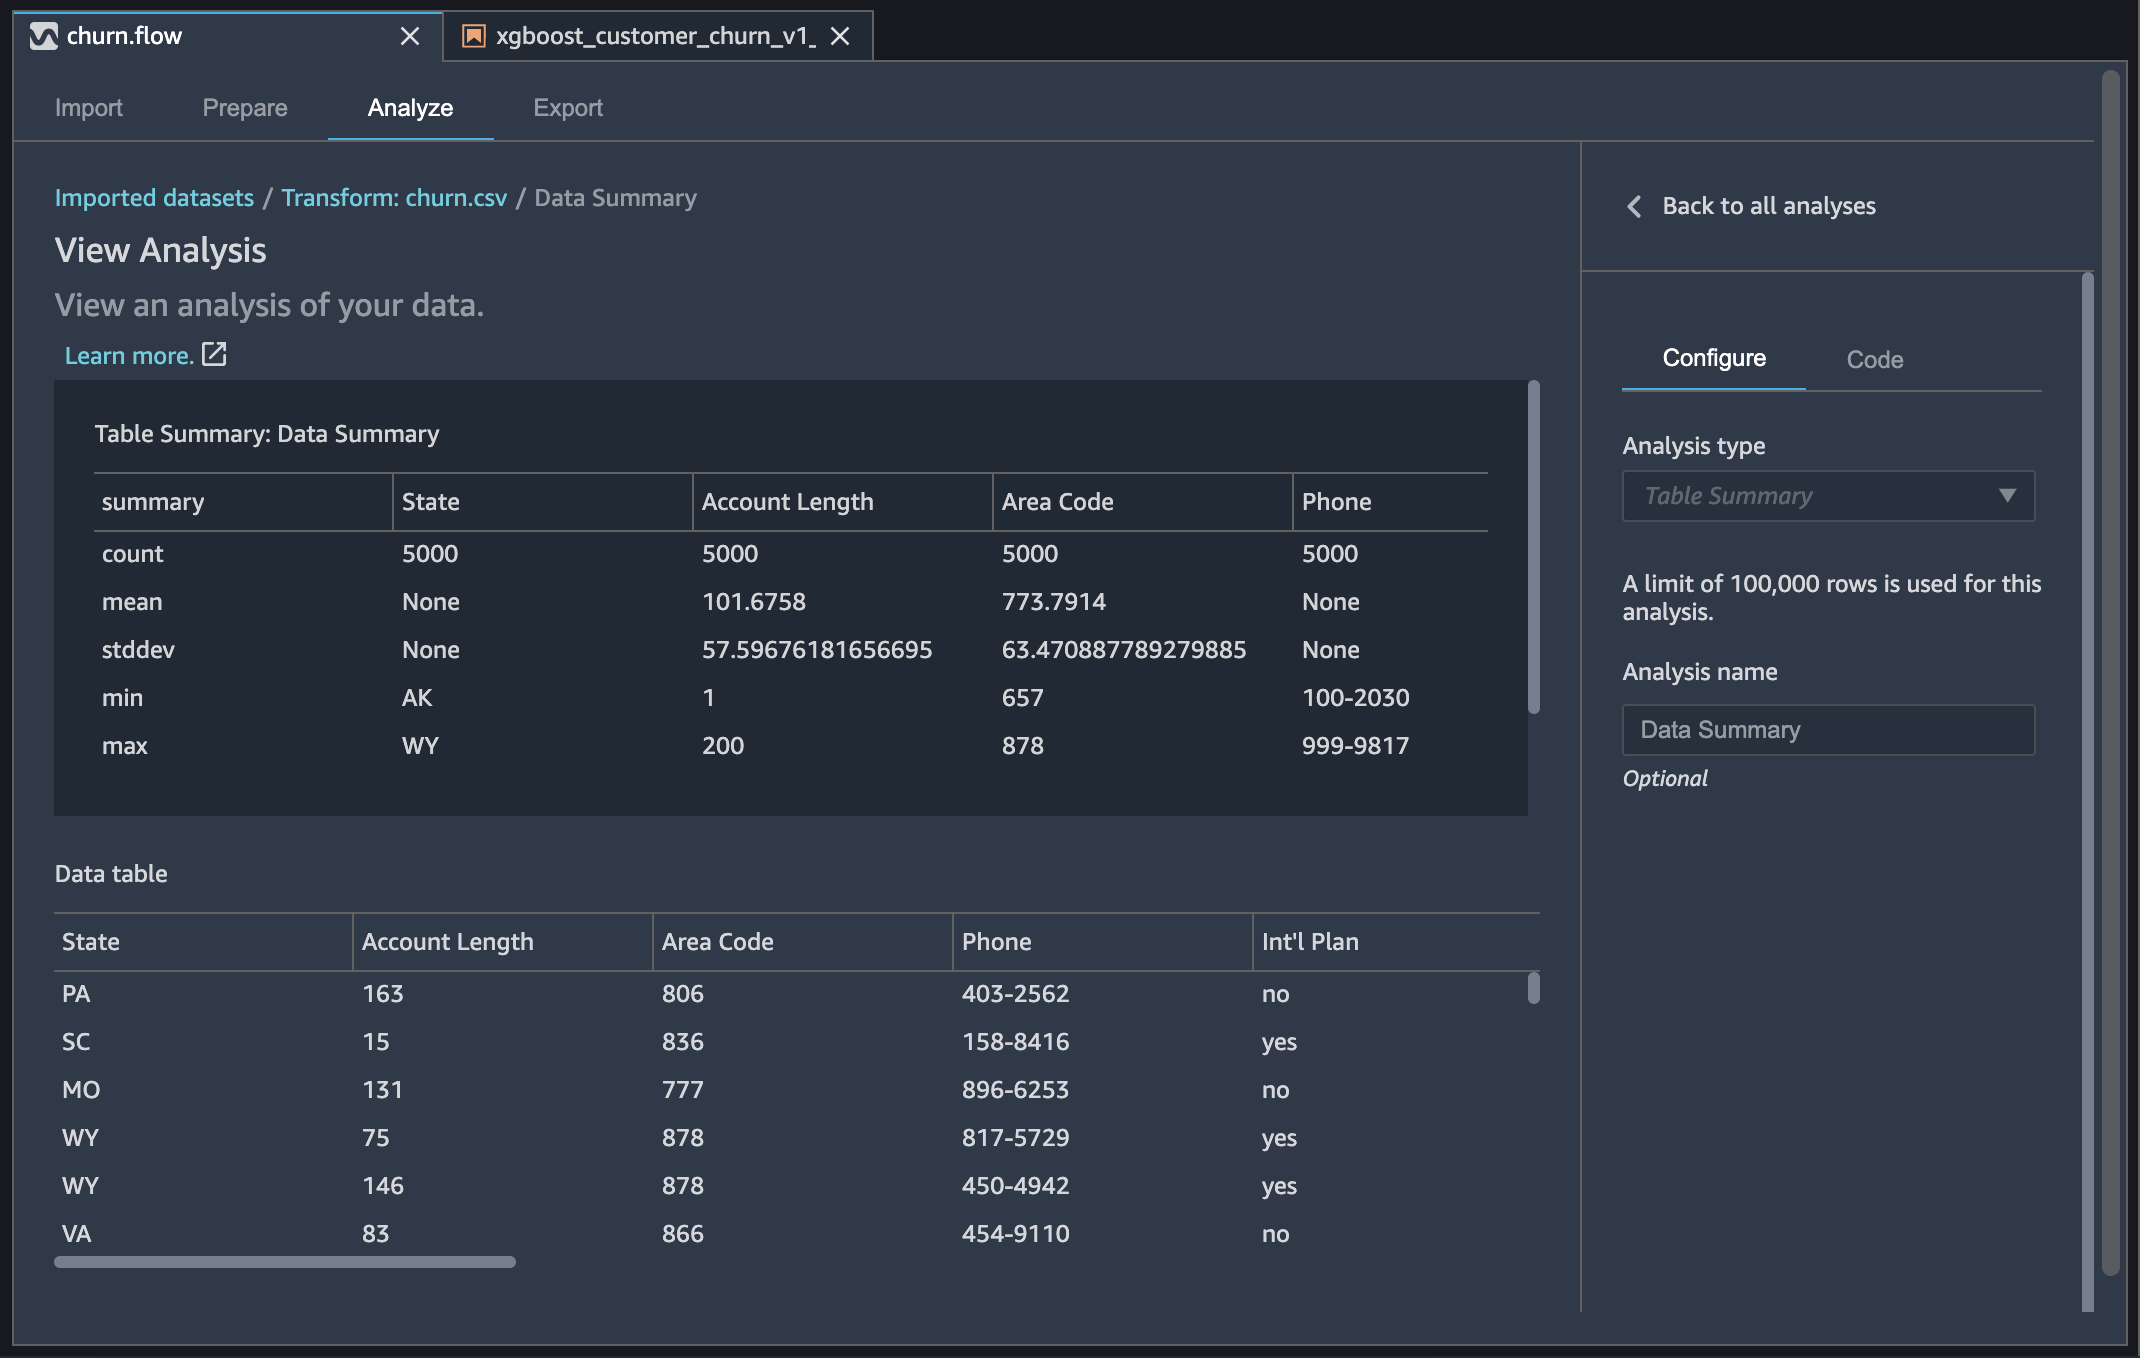

By modern standards, it’s a relatively small dataset, with only 5,000 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Continuing our data analysis, we can leverage different Analysis type on Data Wrangler. Next, we can use Histogram to understand our feature distribution and how it impacts our target value. Going back to the "Analyze" tab, we can add a new Analysis. Then, we can choose Histogram as the "Analysis type" and select a feature to explore its distribution. On the following images we've chosen `Account Length` as feature and colored it by our target variable `Churn?`.

<img src="media/09-analyze_tab_create_new_analysis.png" width="100%" />

<img src="media/10-account_length_histogram.png" width="100%" />

As we can see, we are able to check the distribution of our feature and how its distribution relates to our target value. Feel free to create new histograms for any other feature!

For our last analysis, we'll leverage the "Quick Model" analysis provided by Data Wrangler. This analysis trains a Random Forest algorithm on its own and calculates a feature importance score for each feature on our dataset. You can learn more about the "Quick Model" analysis on this [page](https://docs.aws.amazon.com/sagemaker/latest/dg/data-wrangler-analyses.html#data-wrangler-quick-model) of the Amazon SageMaker Data Wrangler documentation.

<img src="media/11-quick_model_analysis.png" width="100%" />

The higher the score, the more important the feature is. Therefore, feature `Day Mins` is the most important feature on our dataset according to the "Quick Model" analysis.

# Data Transforms on Data Wrangler
Follow the instructions on the image below:  
1 - Click on the plus (+) button  
2 - Click Edit data types  

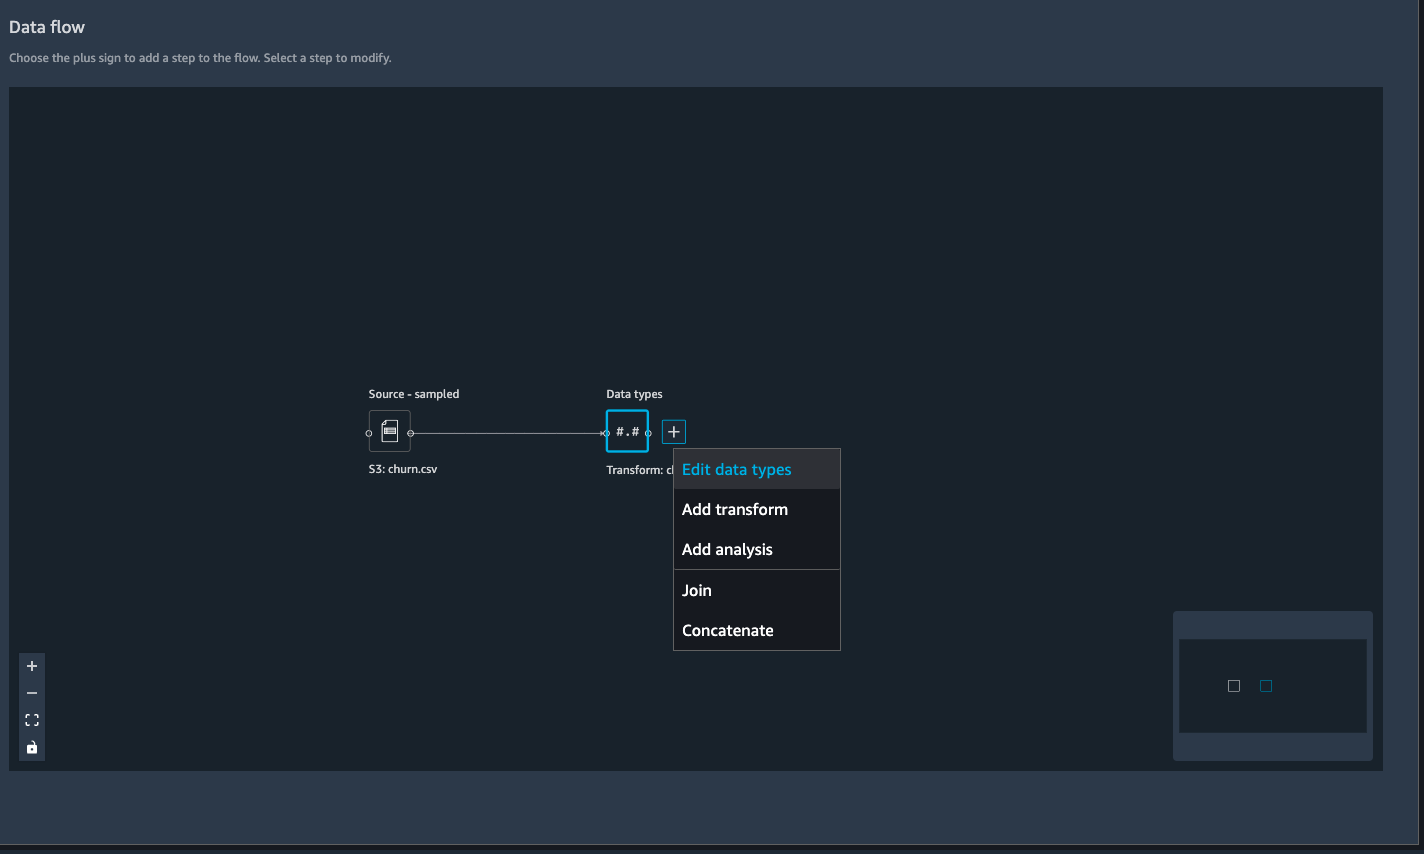

In [9]:
display.Image("1-edit data types.png")

3 - Find the column you want to change  
4 - Select the desired type from the dropdown
5 - Click preview  
6 - Click Add

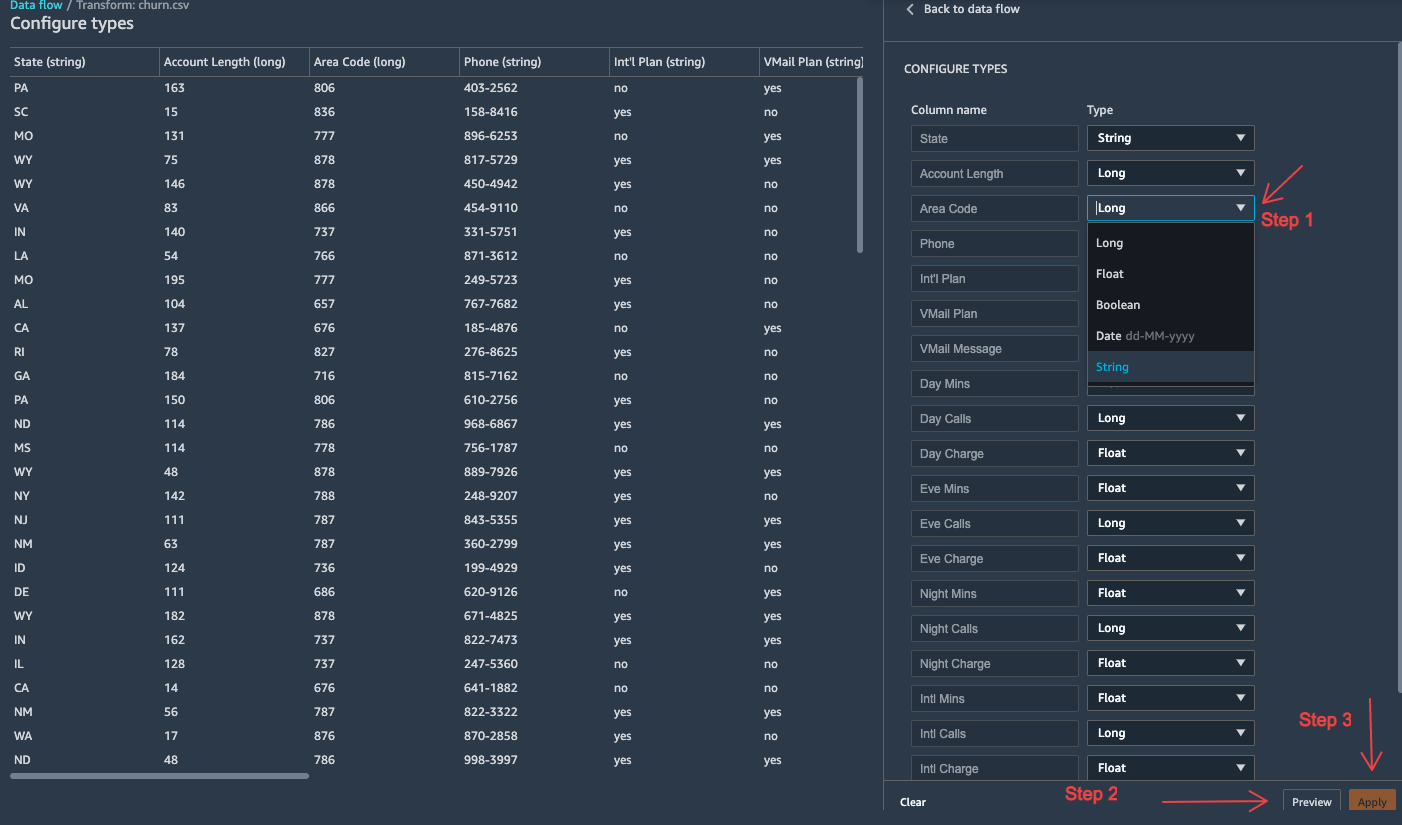

In [10]:
display.Image("2-Area Code to Object.png")

Once you finish, click "Back to data flow" on the top right corner

### Now lets drop the Phone column by adding a Transform  
1 - Click the plus (+)  
2 - Add Transform

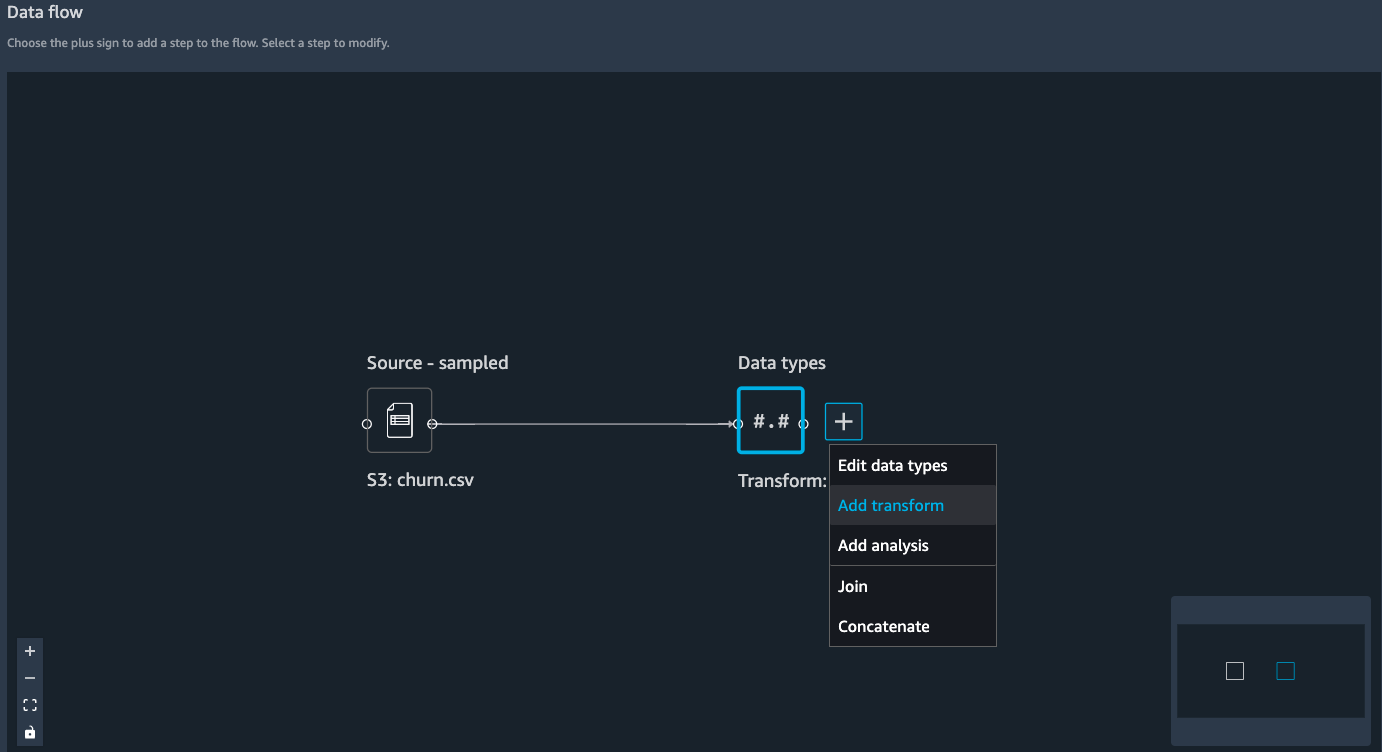

In [11]:
display.Image("3-Add Transform.png")

3 - Click on manage columns  
4 - Select the Phone column from the dropdown (as shown in step 2)  
5 - Click on preview  
6 - Click add

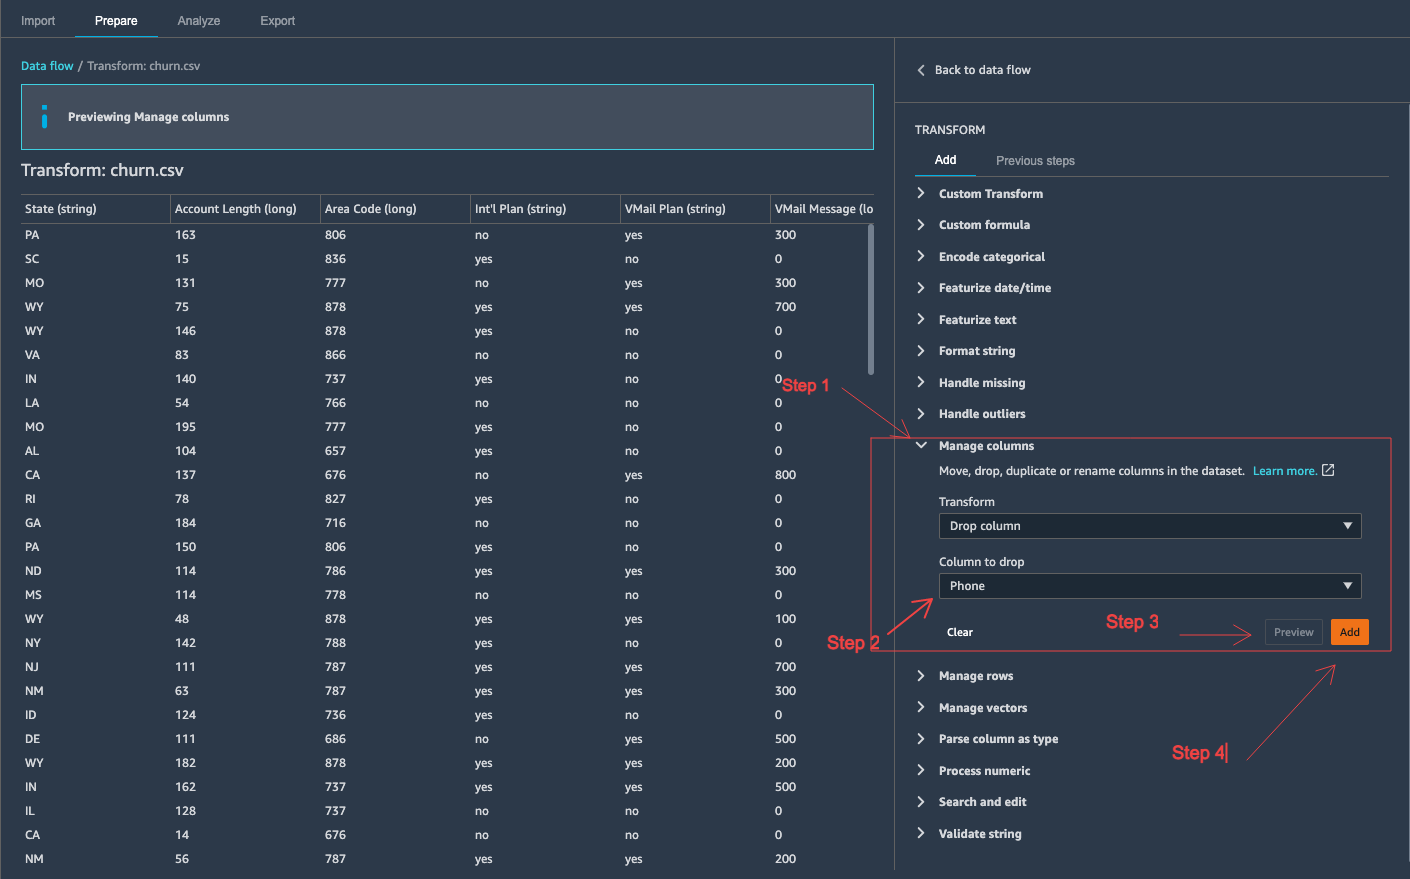

In [12]:
display.Image("4-Steps Drop Phone col.png")

### Now lets Drop a few more columns  
I'll be dropping the first (Day Charge) as an example, just repeat the steps in the image below for the following columns:
* "Day Charge"
* "Eve Charge"
* "Night Charge"
* "Intl Charge"

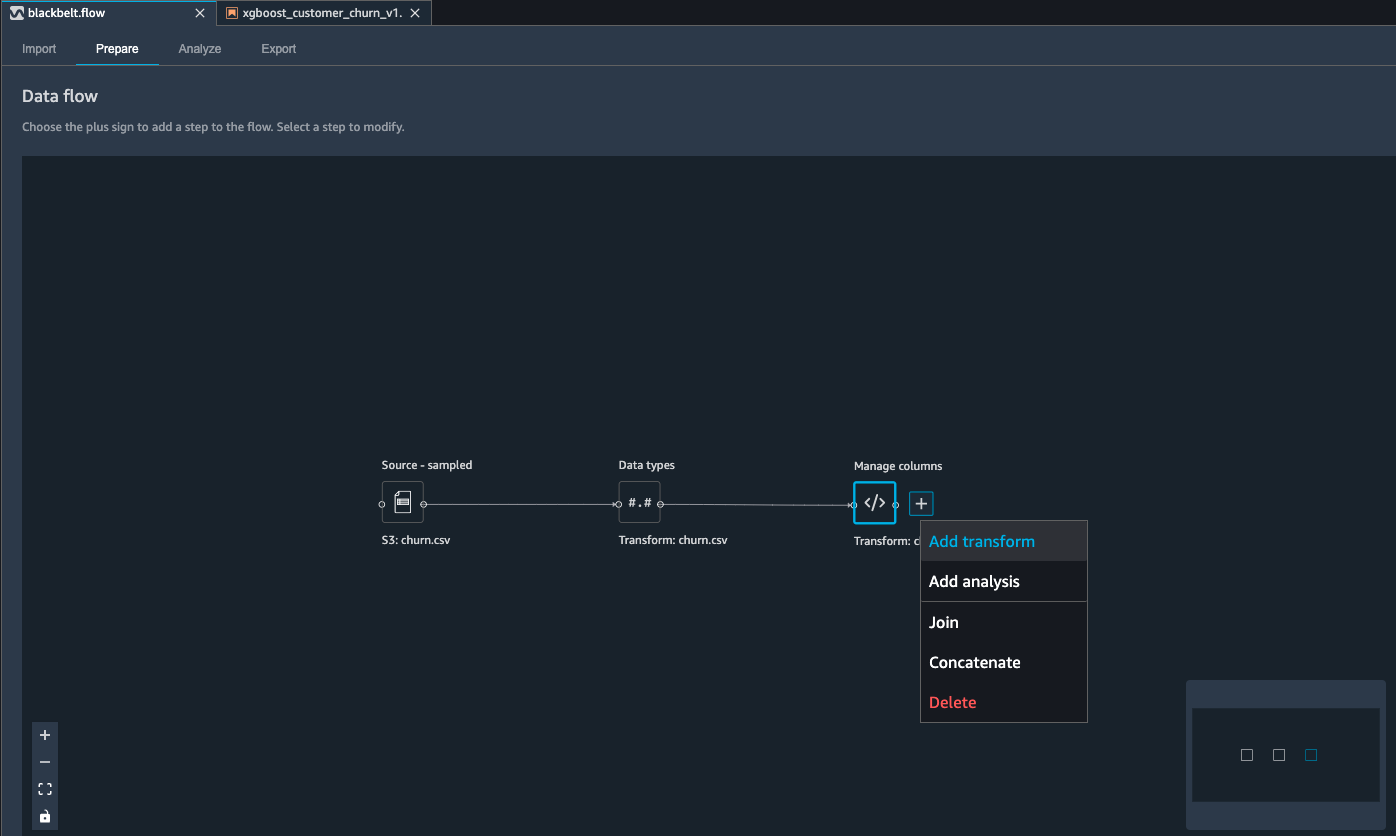

In [8]:
display.Image("5-Adding new Transform.png")

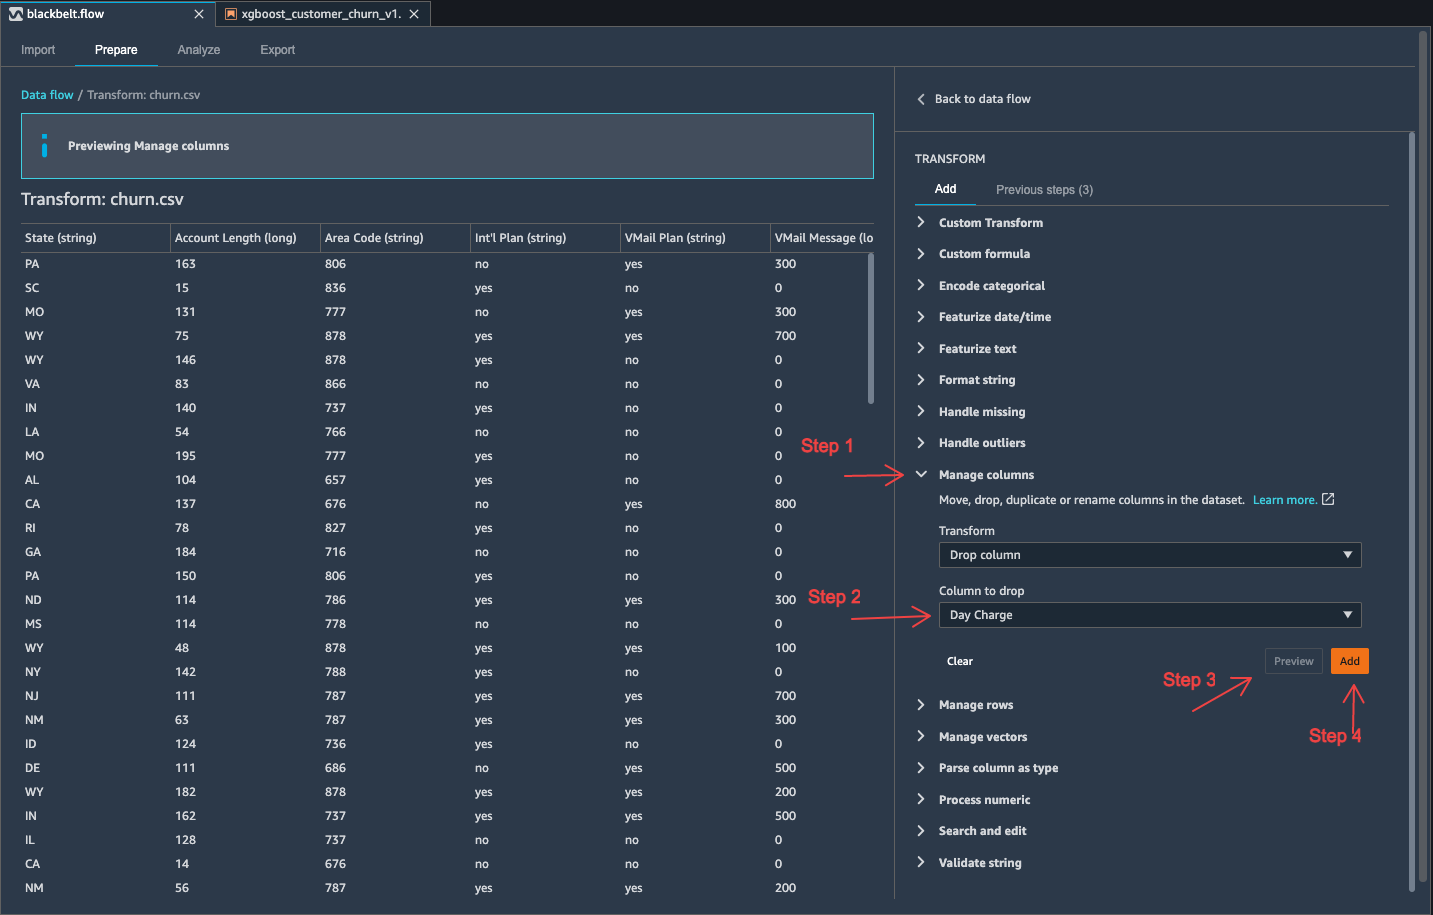

In [9]:
display.Image("6-Drop column pt2.png")

### Now lets do OneHot Encoding using a custom transform
You can copy the code for the custom transform here:
```python
import pandas as pd
model_data = pd.get_dummies(df)
df = pd.concat(
    [model_data["Churn?_True."],
     model_data.drop(["Churn?_False.", "Churn?_True."], axis=1)],
     axis=1
    )
```

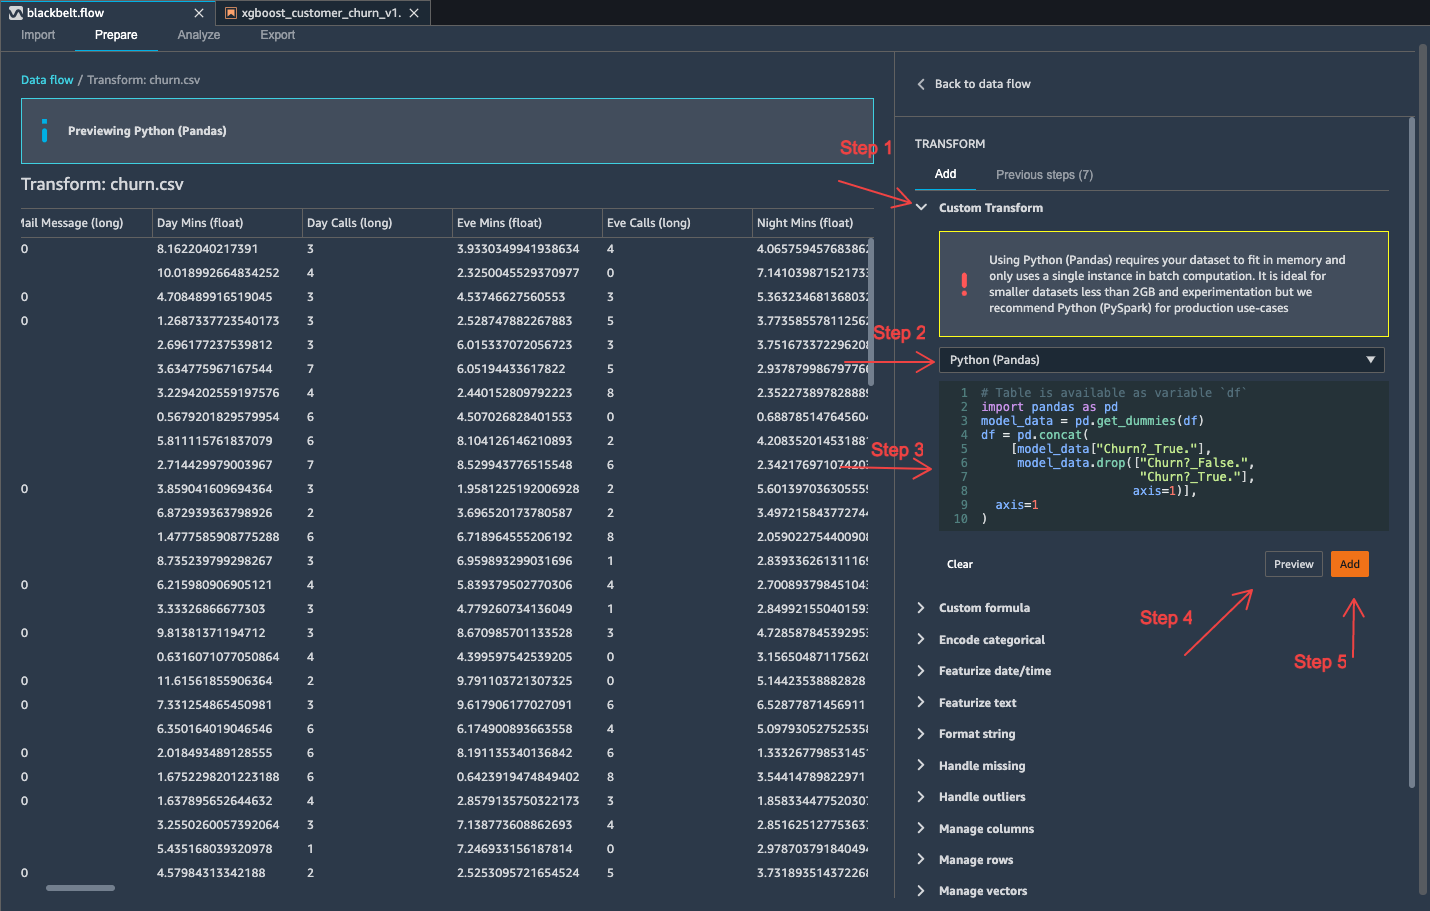

In [10]:
display.Image("7-Custom Transform.png")

And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

# Exporting Transformed data on Data Wrangler

After performing the transformations needed on our dataset, we'll export the transformed data to our S3 bucket. We are able to do so inside Data Wrangler UI by following the steps highlighted on the images below.

<img src="media/12-select_transforms_to_export.png" width="100%" />

<img src="media/13-exporting_to_s3.png" width="100%" />

After selecting the Save to S3 option, a new notebook will be displayed similar to the one presented on the image below.

<img src="media/14-export_to_s3_notebook.png" width="100%" />

We can proceed to Run all cells, as descrribed in the notebook. The processing job will start and it will take a few minutes to finish. Upon completion, we'll see a similar output on the cell presented on the following image.

<img src="media/15-processing_job_finished.png" width="100%" />

Then, we'll navigate to the S3 path on a different browser tab where the job results were saved and download it (see the first line of the previous cell output). Next, we'll upload it to our current Amazon SageMaker Studio environment. The following image shows the download process.

<img src="media/16-download_transformed_data_s3.png" width="100%" />
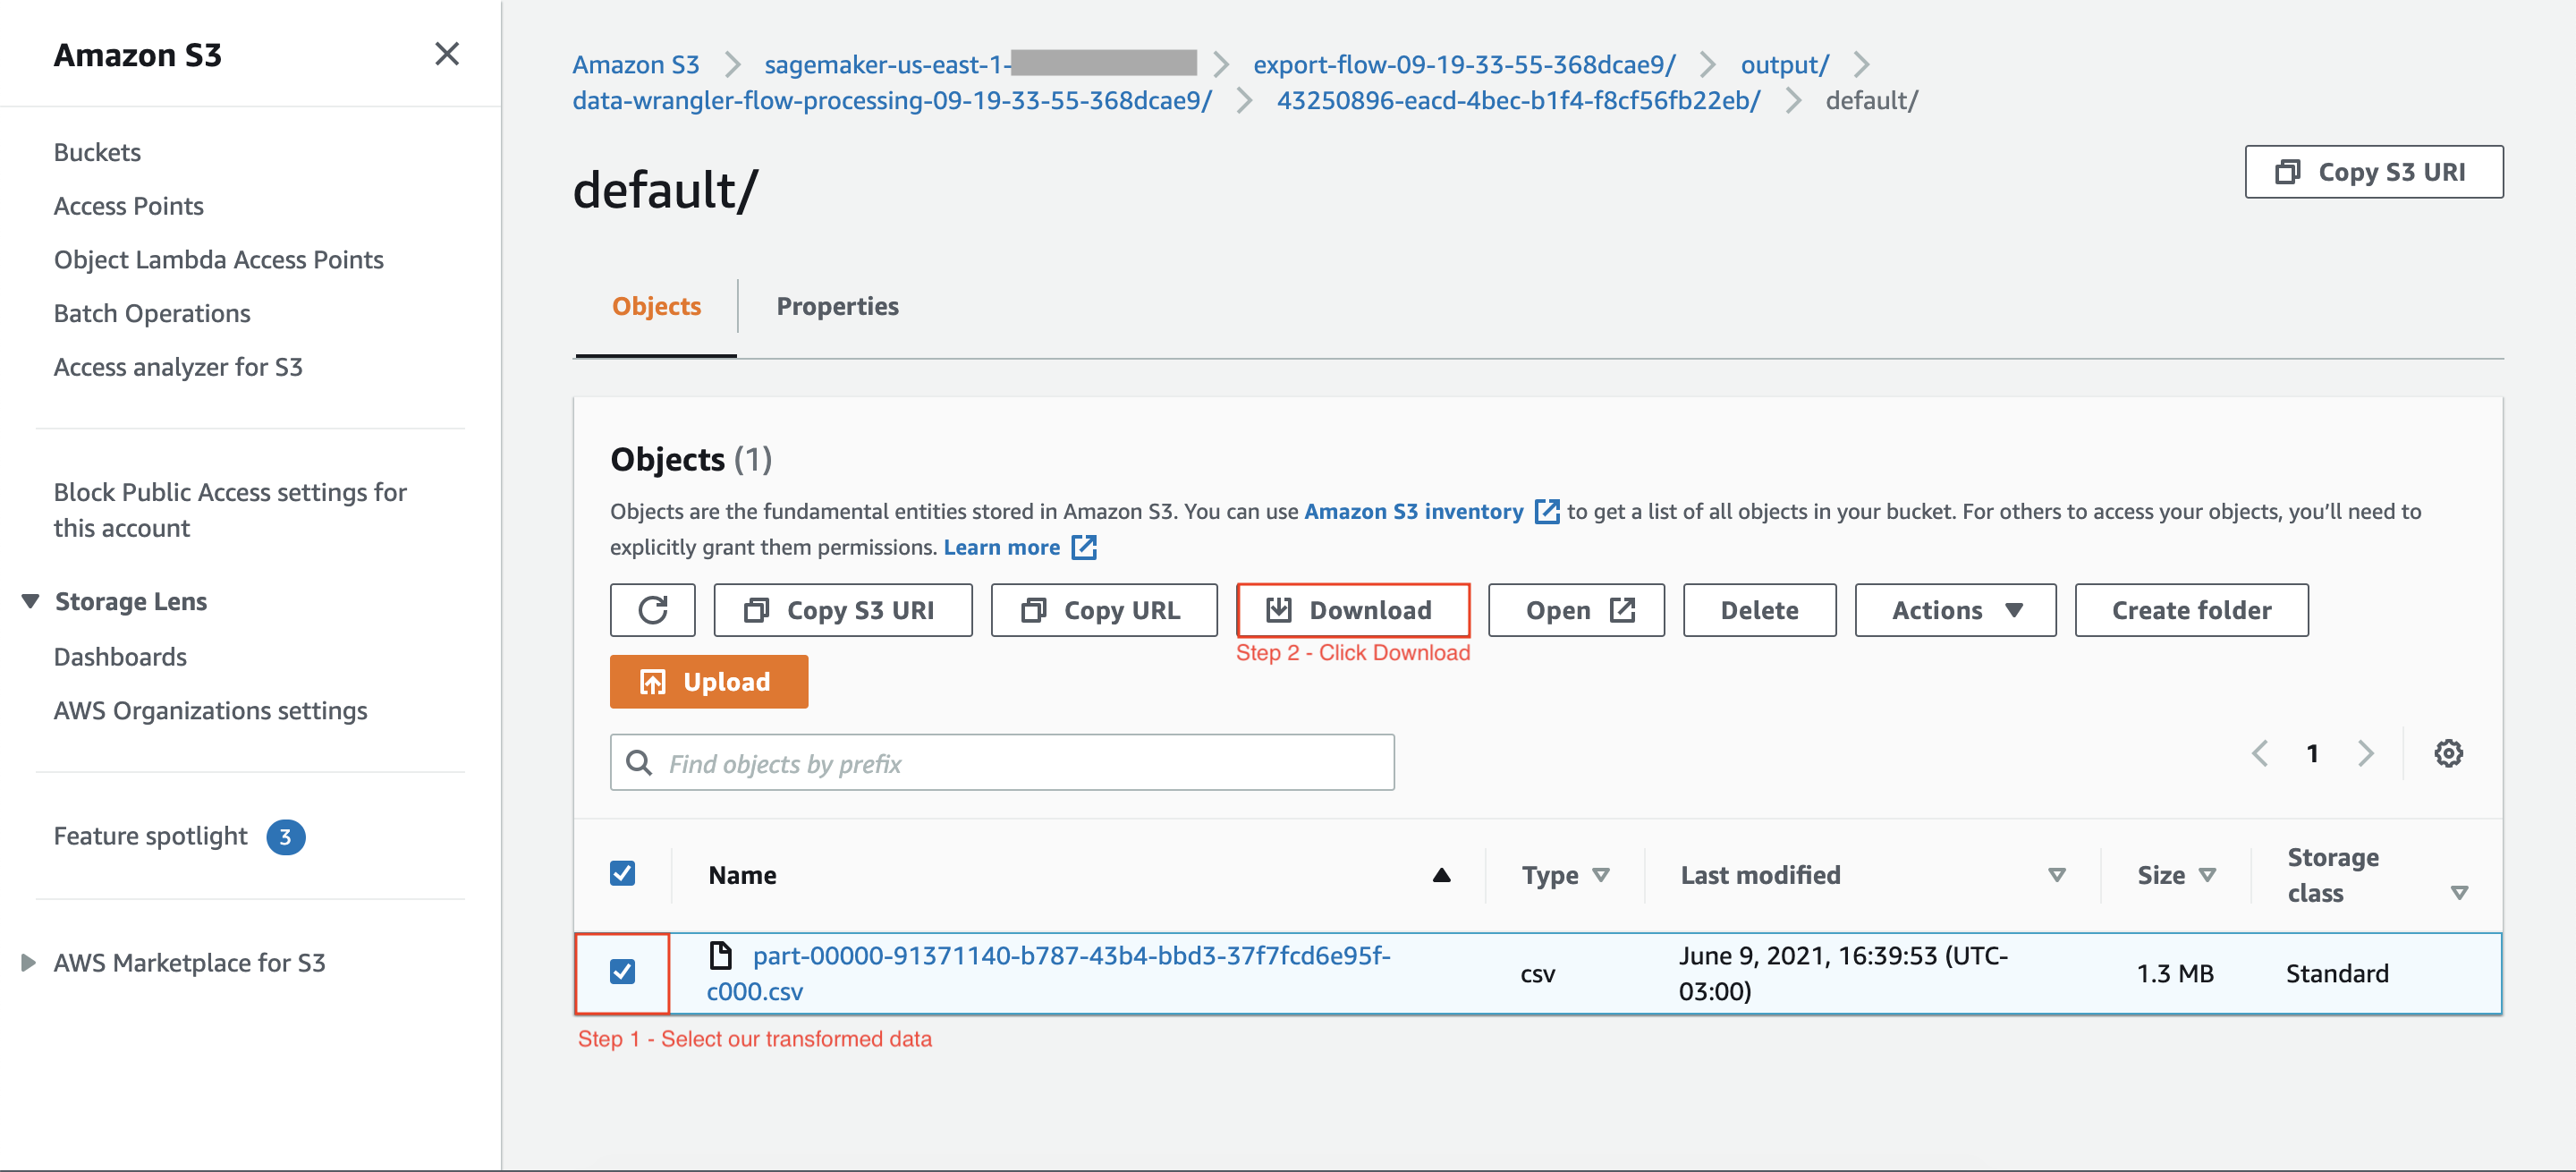

After downloading our transformed data and renaming it, for this workshop we can use `churn_transformed.csv`, we can proceed to upload it to our Amazon SageMaker Studio environment, as shown in the next image.

<img src="media/17-upload_transformed_data.png" width="100%" />

Then, we'll split our data into a train and validation set.

In [30]:
model_data = pd.read_csv("./churn_transformed.csv")
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

Lastly, we'll upload these files to S3.

In [31]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")